# EE 641, Fall 2024 - Homework #1
## Region-based convolutional neural networks (R-CNN)

### Overview

Fine-tune a PyTorch R-CNN model to extract text from natural scenes (see figure below).  Given a scene input your model should output a list of bounding boxes corresponding to each text region.  

Prepare:
  1. validation figures that show machine-predicted bounding boxes vs. the ground-truth boxes
  1. loss-curves that show component-wise R-CNN losses as a function of epoch

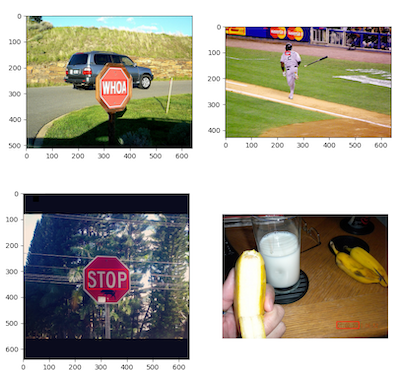

### Dataset

Train your model using the **Text** MS-COCO dataset.  Text MS-COCO is a subset of the original MS-COCO dataset (2014) with additional text annotations.  Read more: [COCO Text](https://bgshih.github.io/cocotext/)

We prepared a copy of the dataset with some minimal cleaning: https://data.usc-ece.com. Download the dataset and extract (unzip) the images.  If you are using CoLab you _can_ download each session using a direct url but it is better to copy the file to your GDrive and mount into your notebook:

```
from google.colab import drive
drive.mount('/content/drive')
# > Mounted at /content/drive

!unzip /content/drive/MyDrive/ee641/datasets/data.zip

# (optional, cleanup)
!rm data.zip
!rm -rf /content/sample_data
```

Then download the JSON annotation file that includes target bounding boxes and contained content.

```
Downloading...
From: https://data.usc-ece.com/EE641/HW1/COCO_Text.json
To: /content/COCO_Text.json`
100% 67.4M/67.4M [00:01<00:00, 56.6MB/s]
```

## Helpers (Complete, but you may modify)

In [1]:
#@title Imports
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import os
import cv2
import numpy as np
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
import torch
import shutil
import time

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title COCO_Text class: Handles the annotation file
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__author__ = 'andreasveit'
__version__ = '1.1'
# Interface for accessing the COCO-Text dataset.

# COCO-Text is a large dataset designed for text detection and recognition.
# This is a Python API that assists in loading, parsing and visualizing the 
# annotations. The format of the COCO-Text annotations is also described on 
# the project website http://vision.cornell.edu/se3/coco-text/. In addition to this API, please download both
# the COCO images and annotations.
# This dataset is based on Microsoft COCO. Please visit http://mscoco.org/
# for more information on COCO, including for the image data, object annotatins
# and caption annotations. 

# An alternative to using the API is to load the annotations directly
# into Python dictionary:
# with open(annotation_filename) as json_file:
#     coco_text = json.load(json_file)
# Using the API provides additional utility functions.

# The following API functions are defined:
#  COCO_Text  - COCO-Text api class that loads COCO annotations and prepare data structures.
#  getAnnIds  - Get ann ids that satisfy given filter conditions.
#  getImgIds  - Get img ids that satisfy given filter conditions.
#  loadAnns   - Load anns with the specified ids.
#  loadImgs   - Load imgs with the specified ids.
#  showAnns   - Display the specified annotations.
#  loadRes    - Load algorithm results and create API for accessing them.
# Throughout the API "ann"=annotation, "cat"=category, and "img"=image.

# COCO-Text Toolbox.        Version 1.1
# Data and  paper available at:  http://vision.cornell.edu/se3/coco-text/
# Code based on Microsoft COCO Toolbox Version 1.0 by Piotr Dollar and Tsung-Yi Lin
# extended and adapted by Andreas Veit, 2016.
# Licensed under the Simplified BSD License [see bsd.txt]

import json
import datetime
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, PathPatch
from matplotlib.path import Path
import numpy as np
import copy
import os

class COCO_Text:
    def __init__(self, annotation_file=None):
        """
        Constructor of COCO-Text helper class for reading and visualizing annotations.
        :param annotation_file (str): location of annotation file
        :return:
        """
        # load dataset
        self.dataset = {}
        self.anns = {}
        self.imgToAnns = {}
        self.catToImgs = {}
        self.imgs = {}
        self.cats = {}
        self.val = []
        self.test = []
        self.train = []
        if not annotation_file == None:
            assert os.path.isfile(annotation_file), "file does not exist"
            print('loading annotations into memory...')
            time_t = datetime.datetime.utcnow()
            dataset = json.load(open(annotation_file, 'r'))
            print(datetime.datetime.utcnow() - time_t)
            self.dataset = dataset
            self.createIndex()

    def createIndex(self):
        # create index
        print('creating index...')
        self.imgToAnns = {int(cocoid): self.dataset['imgToAnns'][cocoid] for cocoid in self.dataset['imgToAnns']}
        self.imgs      = {int(cocoid): self.dataset['imgs'][cocoid] for cocoid in self.dataset['imgs']}
        self.anns      = {int(annid): self.dataset['anns'][annid] for annid in self.dataset['anns']}
        self.cats      = self.dataset['cats']
        self.val       = [int(cocoid) for cocoid in self.dataset['imgs'] if self.dataset['imgs'][cocoid]['set'] == 'val']
        self.test      = [int(cocoid) for cocoid in self.dataset['imgs'] if self.dataset['imgs'][cocoid]['set'] == 'test']
        self.train     = [int(cocoid) for cocoid in self.dataset['imgs'] if self.dataset['imgs'][cocoid]['set'] == 'train']
        print('index created!')

    def info(self):
        """
        Print information about the annotation file.
        :return:
        """
        for key, value in self.dataset['info'].items():
            print('%s: %s'%(key, value))

    def filtering(self, filterDict, criteria):
        return [key for key in filterDict if all(criterion(filterDict[key]) for criterion in criteria)]

    def getAnnByCat(self, properties):
        """
        Get ann ids that satisfy given properties
        :param properties (list of tuples of the form [(category type, category)] e.g., [('readability','readable')] 
            : get anns for given categories - anns have to satisfy all given property tuples
        :return: ids (int array)       : integer array of ann ids
        """
        return self.filtering(self.anns, [lambda d, x=a, y=b:d[x] == y for (a,b) in properties])

    def getAnnIds(self, imgIds=[], catIds=[], areaRng=[]):
        """
        Get ann ids that satisfy given filter conditions. default skips that filter
        :param imgIds  (int array)     : get anns for given imgs
               catIds  (list of tuples of the form [(category type, category)] e.g., [('readability','readable')] 
                : get anns for given cats
               areaRng (float array)   : get anns for given area range (e.g. [0 inf])
        :return: ids (int array)       : integer array of ann ids
        """
        imgIds = imgIds if type(imgIds) == list else [imgIds]
        catIds = catIds if type(catIds) == list else [catIds]

        if len(imgIds) == len(catIds) == len(areaRng) == 0:
            anns = list(self.anns.keys())
        else:
            if not len(imgIds) == 0:
                anns = sum([self.imgToAnns[imgId] for imgId in imgIds if imgId in self.imgToAnns],[])
            else:
                anns = list(self.anns.keys())
            anns = anns if len(catIds)  == 0 else list(set(anns).intersection(set(self.getAnnByCat(catIds)))) 
            anns = anns if len(areaRng) == 0 else [ann for ann in anns if self.anns[ann]['area'] > areaRng[0] and self.anns[ann]['area'] < areaRng[1]]
        return anns

    def getImgIds(self, imgIds=[], catIds=[]):
        '''
        Get img ids that satisfy given filter conditions.
        :param imgIds (int array) : get imgs for given ids
        :param catIds (int array) : get imgs with all given cats
        :return: ids (int array)  : integer array of img ids
        '''
        imgIds = imgIds if type(imgIds) == list else [imgIds]
        catIds = catIds if type(catIds) == list else [catIds]

        if len(imgIds) == len(catIds) == 0:
            ids = list(self.imgs.keys())
        else:
            ids = set(imgIds)
            if not len(catIds) == 0:
                ids  = ids.intersection(set([self.anns[annid]['image_id'] for annid in self.getAnnByCat(catIds)]))
        return list(ids)

    def loadAnns(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying anns
        :return: anns (object array) : loaded ann objects
        """
        if type(ids) == list:
            return [self.anns[id] for id in ids]
        elif type(ids) == int:
            return [self.anns[ids]]

    def loadImgs(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying img
        :return: imgs (object array) : loaded img objects
        """
        if type(ids) == list:
            return [self.imgs[id] for id in ids]
        elif type(ids) == int:
            return [self.imgs[ids]]

    def showAnns(self, anns, show_polygon=False):
        """
        Display the specified annotations.
        :param anns (array of object): annotations to display
        :return: None
        """
        if len(anns) == 0:
            return 0
        ax = plt.gca()
        boxes = []
        color = []
        for ann in anns:
            c = np.random.random((1, 3)).tolist()[0]
            if show_polygon:
                tl_x, tl_y, tr_x, tr_y, br_x, br_y, bl_x, bl_y = ann['polygon']
                verts = [(tl_x, tl_y), (tr_x, tr_y), (br_x, br_y), (bl_x, bl_y), (0, 0)]
                codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
                path = Path(verts, codes)
                patch = PathPatch(path, facecolor='none')
                boxes.append(patch)
                left, top = tl_x, tl_y
            else:
                left, top, width, height = ann['bbox']
                boxes.append(Rectangle([left,top],width,height,alpha=0.4))
            color.append(c)
            if 'utf8_string' in list(ann.keys()):
                ax.annotate(ann['utf8_string'],(left,top-4),color=c)
        p = PatchCollection(boxes, facecolors=color, edgecolors=(0,0,0,1), linewidths=3, alpha=0.4)
        ax.add_collection(p)

    def loadRes(self, resFile):
        """
        Load result file and return a result api object.
        :param   resFile (str)     : file name of result file
        :return: res (obj)         : result api object
        """
        res = COCO_Text()
        res.dataset['imgs'] = [img for img in self.dataset['imgs']]

        print('Loading and preparing results...     ')
        time_t = datetime.datetime.utcnow()
        if type(resFile) == str:
            anns = json.load(open(resFile))
        else:
            anns = resFile
        assert type(anns) == list, 'results in not an array of objects'
        annsImgIds = [int(ann['image_id']) for ann in anns]
        
        if set(annsImgIds) != (set(annsImgIds) & set(self.getImgIds())):
            print('Results do not correspond to current coco set')
            print('skipping ', str(len(set(annsImgIds)) - len(set(annsImgIds) & set(self.getImgIds()))), ' images')
        annsImgIds = list(set(annsImgIds) & set(self.getImgIds()))

        res.imgToAnns = {cocoid : [] for cocoid in annsImgIds}
        res.imgs = {cocoid: self.imgs[cocoid] for cocoid in annsImgIds} 

        assert anns[0]['bbox'] != [], 'results have incorrect format'
        for id, ann in enumerate(anns):
            if ann['image_id'] not in annsImgIds:
                continue
            bb = ann['bbox']
            ann['area'] = bb[2]*bb[3]
            ann['id'] = id
            res.anns[id] = ann
            res.imgToAnns[ann['image_id']].append(id)
        print('DONE (t=%0.2fs)'%((datetime.datetime.utcnow() - time_t).total_seconds()))

        return res

### CocoDataset class (TODO)

TODO: `CocoDataset::__getitem__()`

In [3]:
#@title Dataset class: use images and annotation file to implement a dataset that can used with Dataloader

class CocoDataset(Dataset):
    def __init__(self, root_dir, annFile, transform=None, cuda=True):
        self.root_dir = root_dir
        self.transform = transform
        self.imgs = os.listdir(root_dir)
        # annotations
        self.ct = COCO_Text(annFile)
        self.imgIds = self.ct.getImgIds(imgIds=self.ct.train, 
                    catIds=[('legibility','legible'),('class','machine printed')])
        
        for imgId in self.imgIds:
            file_name = self.ct.loadImgs(imgId)[0]['file_name']
            if file_name not in self.imgs:
                self.imgIds.remove(imgId)
        # manual exclude
        self.imgIds.remove(275939)
        self.imgIds.remove(443671)

        # remaining images
        print(f"remaining images in ann file: {len(self.imgIds)}, remaining images in folder: {len(self.imgs)}")

        self.imgIds.sort()
        # sort the images in same order as the annotations
        self.imgs = [self.ct.loadImgs(imgId)[0]['file_name'] for imgId in self.imgIds]

        self.img_h = 224
        self.img_w = 224
        self.cuda = cuda
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
    # Get image ID
        img_id = self.imgIds[idx]
    
    # Load image using the COCO_Text helper
        img_info = self.ct.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")
    
    # Get original image dimensions
        original_width, original_height = image.size
    
    # Get annotations for the image
        ann_ids = self.ct.getAnnIds(imgIds=[img_id], catIds=[('legibility','legible'),('class','machine printed')])
        anns = self.ct.loadAnns(ann_ids)
    
    # Extract bounding boxes and convert them to the required format
        boxes = []
        for ann in anns:
        # COCO format: [top-left x, top-left y, width, height]
            x, y, width, height = ann['bbox']
            boxes.append([x, y, x + width, y + height])
    
    # Convert boxes to torch tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
    
    # Define the target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.ones((len(boxes),), dtype=torch.int64)  # Use 1 as label for all boxes since this is a single-class problem
        target["image_id"] = torch.tensor([img_id])
    
    # Apply transformations, if any
        if self.transform:
        # Apply the transformation to the image
            image = self.transform(image)
        
        # Adjust bounding boxes to the resized image dimensions (224x224 in this case)
            scale_x = 224 / original_width
            scale_y = 224 / original_height
        
        # Update the bounding boxes accordingly
            target["boxes"][:, [0, 2]] *= scale_x  # Adjust x-coordinates (x_min, x_max)
            target["boxes"][:, [1, 3]] *= scale_y  # Adjust y-coordinates (y_min, y_max)

        return image, target

# coalate_fn is used to collate the data into batches
def collate_fn(batch):
    images = []
    targets = []
    for item in batch:
        images.append(item[0])
        targets.append(item[1])
    images = torch.stack(images, 0)
    return images, targets

# Evaluate / region visualization (TODO)

Load four images and predict regions using model.
Create a figure that shows the images as subplots. 
Overlay model predicted regions (blue) and target regions (red).
Save the output as an image -- use epoch in filename to preserve order.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def evaluate(model, dataloader, device, epoch):
    # Set model to evaluation mode
    model.eval()
    
    # Load four images
    images, targets = next(iter(dataloader))
    
    # Move images and targets to the device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Make predictions
    with torch.no_grad():
        predictions = model(images)
    
    # Create a figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    for i in range(4):
        ax = axs[i // 2, i % 2]
        
        # Convert tensor image back to NumPy for visualization
        img_np = images[i].cpu().permute(1, 2, 0).numpy()
        
        # Denormalize the image if necessary (here assuming images are normalized between 0 and 1)
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        
        ax.imshow(img_np)
        
        # Plot ground-truth bounding boxes (red)
        for box in targets[i]['boxes'].cpu().numpy():
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        
        # Plot predicted bounding boxes (blue)
        for box in predictions[i]['boxes'].cpu().numpy():
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
        
        ax.set_title(f"Image {i + 1}")
        ax.axis('off')
    
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f"evaluation_epoch_{epoch}.png")
    plt.show()
    
    # Set model back to training mode
    model.train()


# Model factory (TODO)

Use a pretrained torchvision model. Keep training resources in mind when selecting a model. Make changes necessary to adapt the pretrained network to this dataset.  [Example](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [5]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import mobilenet_v3_small
from torchvision.models.detection.backbone_utils import BackboneWithFPN

def get_model(num_classes=2):
    """
    Create and return a Faster R-CNN model with a MobileNetV3-Small backbone.
    Args:
        num_classes: Number of output classes (including background). Default is 2 for text detection.

    Returns:
        model: A PyTorch Faster R-CNN model adapted for text detection.
    """
    # Load a pretrained MobileNetV3-Small model
    backbone = mobilenet_v3_small(pretrained=True).features
    backbone.out_channels = 576  # Output channels for MobileNetV3-Small

    # Create a Region Proposal Network (RPN) with anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),  # Different sizes of anchors
        aspect_ratios=((0.5, 1.0, 2.0),) * 5  # Aspect ratios
    )

    # Define the feature map names (matching the layers of the backbone output)
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2
    )

    # Create the Faster R-CNN model using the MobileNetV3-Small backbone
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model


# Setup (TODO)

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the dataset
dataset = CocoDataset(
    root_dir = './data/train' ,
    annFile = './COCO_Text.json',
    transform=transform,
    cuda=False  # Set to False since we are handling the device later
)

# Initialize the DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,  # Choose a batch size suitable for your hardware
    shuffle=True,
    num_workers=0,  # Adjust num_workers based on your machine (increase if you have more CPU cores)
    collate_fn=collate_fn
)

# Initialize the model
model = get_model(num_classes=2)

# Move model to the device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)


loading annotations into memory...
0:00:01.055409
creating index...
index created!
remaining images in ann file: 8738, remaining images in folder: 8738


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_training_samples(dataloader, num_samples=4):
    images, targets = next(iter(dataloader))

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Adjust based on num_samples (e.g., (2, 2) for 4 samples)

    for i in range(num_samples):
        ax = axs[i // 2, i % 2]

        # Convert tensor image back to NumPy for visualization
        img_np = images[i].permute(1, 2, 0).numpy()
        
        # Denormalize the image if necessary (only if you applied normalization)
        img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img_np = np.clip(img_np, 0, 1)  # Clip to valid range

        ax.imshow(img_np)
        
        # Plot ground-truth bounding boxes in red
        for box in targets[i]['boxes'].numpy():
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        
        ax.set_title(f"Sample {i + 1}")
        ax.axis('off')
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()


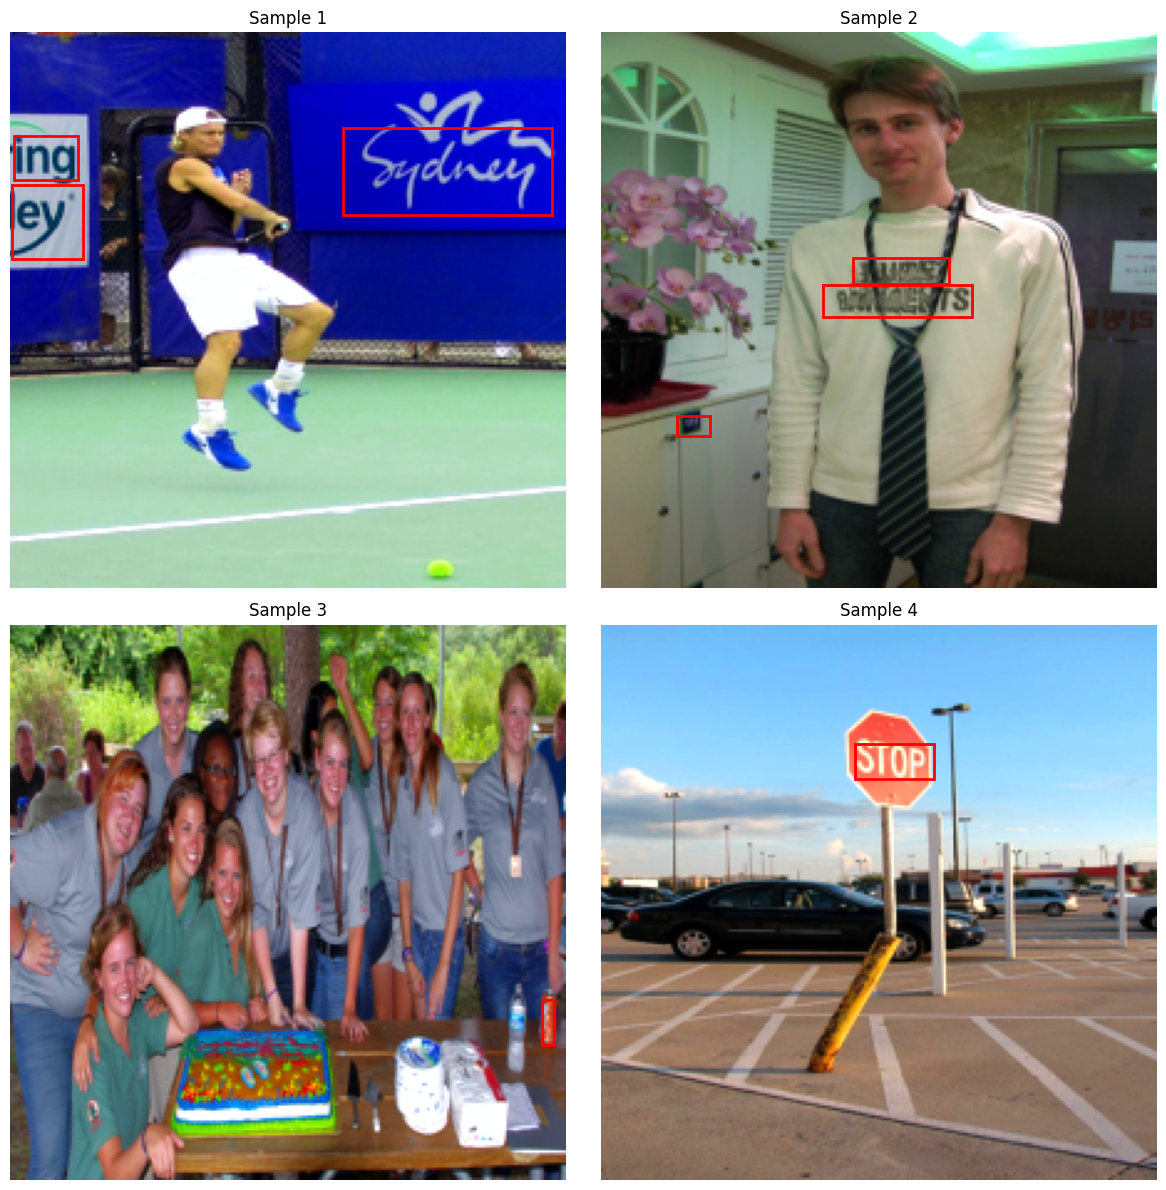

In [8]:
# Visualize the first few samples from the training dataset
visualize_training_samples(dataloader, num_samples=4)


# Training (TODO)

In [9]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# Initialize the optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce LR every 3 epochs
num_epochs = 100

# Initialize lists to track the losses
total_loss_values = []
loss_classifier_values = []
loss_box_reg_values = []
loss_objectness_values = []
loss_rpn_box_reg_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_classifier_loss = 0
    epoch_box_reg_loss = 0
    epoch_objectness_loss = 0
    epoch_rpn_box_reg_loss = 0
    
    for idx, (images, targets) in enumerate(dataloader):
        # Move data to the device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Perform forward pass
        loss_dict = model(images, targets)
        
        # Calculate total loss
        losses = sum(loss for loss in loss_dict.values())
        
        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Clipping with max_norm=2.0
        
        optimizer.step()
        
        # Accumulate losses for the epoch
        epoch_loss += losses.item()
        epoch_classifier_loss += loss_dict['loss_classifier'].item()
        epoch_box_reg_loss += loss_dict['loss_box_reg'].item()
        epoch_objectness_loss += loss_dict['loss_objectness'].item()
        epoch_rpn_box_reg_loss += loss_dict['loss_rpn_box_reg'].item()
        

    # Store the average losses for this epoch
    total_loss_values.append(epoch_loss / len(dataloader))
    loss_classifier_values.append(epoch_classifier_loss / len(dataloader))
    loss_box_reg_values.append(epoch_box_reg_loss / len(dataloader))
    loss_objectness_values.append(epoch_objectness_loss / len(dataloader))
    loss_rpn_box_reg_values.append(epoch_rpn_box_reg_loss / len(dataloader))
    
    # Adjust the learning rate
    scheduler.step()
    
    # Save checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, f"checkpoint_epoch_{epoch + 1}.pth")
    
    # Validate and visualize the bounding boxes
    model.eval()
    evaluate(model, dataloader, device, epoch)

# Plot the loss components
plt.figure(figsize=(10, 6))
plt.plot(total_loss_values, label='Total Loss')
plt.plot(loss_classifier_values, label='Loss Classifier')
plt.plot(loss_box_reg_values, label='Loss Box Regression')
plt.plot(loss_objectness_values, label='Loss Objectness')
plt.plot(loss_rpn_box_reg_values, label='Loss RPN Box Regression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Components vs. Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_components.png')
plt.show()

KeyboardInterrupt: 